# Streaming Data Template

### -----


# WARNING!
# RUN AT YOUR OWN RISK
# THIS CODE IS A MESS.
## Take what you need, leave the rest to suffer.


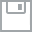
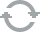
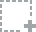
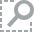
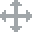
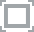
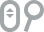
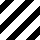
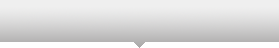
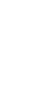
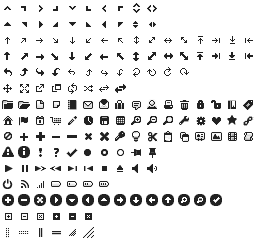
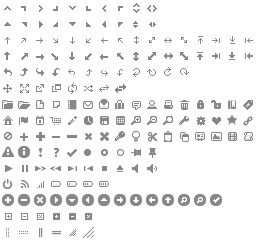
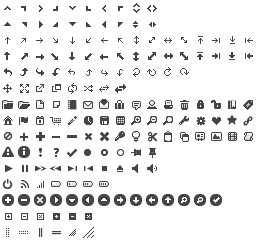
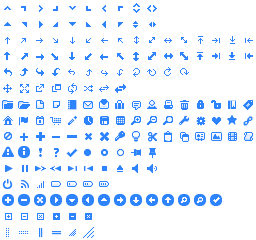
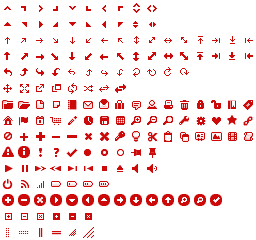
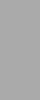
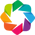
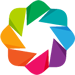

In [22]:
import requests;                                 # import package used to downlaod data from a web URL
import json;
import pandas as pd;
#import seaborn as sns;

import datetime as dt
import time

import matplotlib.pyplot as plt;
import matplotlib;

from bokeh.charts import Scatter, show
from bokeh.io import output_notebook
output_notebook()

import numpy as np

from pandas.io.json import json_normalize

from sklearn import tree
from sklearn import cross_validation

matplotlib.style.use('ggplot');
%matplotlib inline

In [16]:
with open('API Keys.txt', 'r') as keyfile:
    apiKeys=keyfile.read().split('\n')
   
url = 'http://backpack.tf/api/IGetPrices/v4/?key=' + apiKeys[0];        # web address of data stream

data_stream = requests.get(url,stream=True);                                    # create an iterable data stream object

rec = data_stream.iter_lines().next().strip() # Necessary before reading data
data = json.loads(rec)            # convert the json record to a python dictionary

In [38]:
def byteify(input):
    if isinstance(input, dict):
        return {byteify(key): byteify(value)
                for key, value in input.iteritems()}
    elif isinstance(input, list):
        return [byteify(element) for element in input]
    elif isinstance(input, unicode):
        return input.encode('utf-8')
    else:
        return input

data2 = byteify(data)

In [ ]:
#Testing box. Useful/helps me remember. Do not remove.

#dfName = json_normalize(data2['response']['items']["Dillinger's Duffel"]['prices']['6']['Tradable']['Craftable']['0'])#['currency', 'difference', 'value', 'last_update'])
# if(dfName[0][0] == 'prices'):
#     print('Hello')
# dfName = json_normalize(data2['response']['items']["Dillinger's Duffel"], 'prices')
# for qualInt in dfName[0]:
#     dfTrade = json_normalize(data2['response']['items'][itemName]['prices'], qualInt)
#dfName

In [39]:
df = json_normalize(data2['response'])

In [40]:
#Just info that the website gives us.

raw_usd_value = df['raw_usd_value']
current_time = df['current_time']
success = df['success']
usd_currency_index = df['usd_currency_index']
usd_currency = df['usd_currency']

In [41]:
#Note: This is only the item data.
#Does not get raw item data (can easily be added if we want)
#Does not get value_high

#THIS WILL TAKE >2 MINUTES TO RUN

#Might be better to start with some array or something with an initial size (16K ish?)
#then convert when it is done

dfItemFinal = pd.DataFrame(columns = ['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex', 'Currency', 'Value', 'Last_Update', 'Difference'])
df = json_normalize(data2['response'], 'items')
for itemName in df[0]:
    dfName = json_normalize(data2['response']['items'], [itemName])
    if(dfName.size != 2):
        raise Exception('More than 2 items for item' + itemName)
    if(dfName[0][0] != 'prices'):
        raise Exception('First row in %s is not prices' % (itemName))
    if(dfName[0][0] != 'prices'):
        raise Exception('Second row in %s is not defindex' % (itemName))
    defIndex = json_normalize(data2['response']['items'][itemName], ['defindex'])[0][0]
    dfPrices = json_normalize(data2['response']['items'][itemName], 'prices')
    for qualInt in dfPrices[0]:
        dfTrade = json_normalize(data2['response']['items'][itemName]['prices'], qualInt)
        
        for tradeable in dfTrade[0]:
            dfCraft = json_normalize(data2['response']['items'][itemName]['prices'][qualInt], tradeable)
        
            for craftable in dfCraft[0]:
                dfPriceIndex = json_normalize(data2['response']['items'][itemName]['prices'][qualInt][tradeable], craftable)
                
                for priceIndex in dfPriceIndex[0]:
                    dfFinalValues = json_normalize(data2['response']['items'][itemName]['prices'][qualInt][tradeable][craftable][priceIndex])
                    
                    currency = dfFinalValues['currency'][0]
                    difference = dfFinalValues['difference'][0]
                    last_update = dfFinalValues['last_update'][0]
                    value = dfFinalValues['value'][0]
                    dfItemFinal.loc[len(dfItemFinal)]=[itemName, defIndex, qualInt, tradeable, craftable, priceIndex, currency, value, last_update, difference]

In [10]:
#dfItemFinal.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
#dfItemFinal = dfNew.drop('Unnamed: 0', axis=1)
#dfItemFinal.sort_index(inplace = True)
#dfItemFinal.to_csv('itemOut.csv')

ValueError: labels ['Unnamed: 0'] not contained in axis

In [2]:
#dfNew = pd.read_csv('itemOut.csv')
#dfNew = dfNew.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])

col = ['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex', 'Currency', 'Value', 'Last_Update', 'Difference']
dfNew = pd.read_csv('itemOut.csv',names=col)
dfNew = dfNew.ix[1:]

dfNew.sort_index(inplace = True)
#dfNew.head(100)

In [3]:
#Standardize the currency (there are 3 types: metal, keys, and usd. We want to translate them all to metal)
refinedMetalPerKey = dfNew[dfNew['Name'] == 'Mann Co. Supply Crate Key']['Value'].max()
dfNew.ix[dfNew['Currency'] == 'keys', 'Value'] = dfNew.ix[dfNew['Currency'] == 'keys', 'Value'] * refinedMetalPerKey

#Remove usd currency (this is usually pretty uninteresting)
dfNew = dfNew[dfNew['Currency'] != 'usd']
dfNew = dfNew.drop('Currency', axis=1)

TypeError: can't multiply sequence by non-int of type 'str'

In [4]:
dfNew.Value = dfNew.Value.astype('float')
dfNew.DefIndex = dfNew.DefIndex.astype('float')
dfNew.QualInt = dfNew.QualInt.astype('int')

# Load itemhistory

In [16]:
#dfNew = pd.read_csv('itemOut.csv')
#dfNew = dfNew.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])

col = ['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex', 'Timestamp', 'DateTime', 'Currency', 'Value', 'Value_High']
dfAll = pd.read_csv('itemhistory.csv',names=col)
dfAll = dfAll.ix[1:]

#dfAll.sort_index(inplace = True)
dfAll.head(100)

Name DefIndex QualInt     Trade      Craft  \
1             A Brush with Death  30186.0     6.0  Tradable  Craftable   
2             A Brush with Death  30186.0     6.0  Tradable  Craftable   
3             A Brush with Death  30186.0     6.0  Tradable  Craftable   
4             A Brush with Death  30186.0     6.0  Tradable  Craftable   
5             A Brush with Death  30186.0     6.0  Tradable  Craftable   
6             A Brush with Death  30186.0     6.0  Tradable  Craftable   
7             A Brush with Death  30186.0     6.0  Tradable  Craftable   
8             A Brush with Death  30186.0     6.0  Tradable  Craftable   
9             A Brush with Death  30186.0     6.0  Tradable  Craftable   
10            A Brush with Death  30186.0     6.0  Tradable  Craftable   
11            A Brush with Death  30186.0     6.0  Tradable  Craftable   
12            A Brush with Death  30186.0     6.0  Tradable  Craftable   
13            A Brush with Death  30186.0     6.0  Tradable  Craftable   
14            A Brush with Death  30186.0     6.0  Tradable  Craftable   
15            A Brush with Death  30186.0     6.0  Tradable  Craftable   
16            A Brush with Death  30186.0     6.0  Tradable  Craftable   
17            A Brush with Death  30186.0     6.0  Tradable  Craftable   
18            A Brush with Death  30186.0     6.0  Tradable  Craftable   
19            A Brush with Death  30186.0     6.0  Tradable  Craftable   
20            A Brush with Death  30186.0     6.0  Tradable  Craftable   
21            A Brush with Death  30186.0     6.0  Tradable  Craftable   
22            A Brush with Death  30186.0     6.0  Tradable  Craftable   
23            A Brush with Death  30186.0     6.0  Tradable  Craftable   
24            A Brush with Death  30186.0     6.0  Tradable  Craftable   
25            A Brush with Death  30186.0     6.0  Tradable  Craftable   
26            A Brush with Death  30186.0     6.0  Tradable  Craftable   
27            A Brush with Death  30186.0     6.0  Tradable  Craftable   
28            A Brush with Death  30186.0     6.0  Tradable  Craftable   
29      A Color Similar to Slate   5052.0     6.0  Tradable  Craftable   
30      A Color Similar to Slate   5052.0     6.0  Tradable  Craftable   
..                           ...      ...     ...       ...        ...   
71   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
72   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
73   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
74   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
75   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
76   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
77   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
78   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
79   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
80   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
81   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
82   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
83   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
84   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
85   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
86   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
87   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
88   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
89   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
90   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
91   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
92   A Deep Commitment to Purple   5031.0     6.0  Tradable  Craftable   
93   A Deep Commitment to Purple

In [17]:
dfAll['DateTime'] = pd.to_datetime(dfAll['DateTime'])
dfAll = dfAll.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
dfAll.sort_index(inplace = True)
dfAll = dfAll.reset_index()

In [18]:
#Standardize the currency (there are 3 types: metal, keys, and usd. We want to translate them all to metal)
refinedMetalPerKey = float(dfAll[dfAll['Name'] == 'Mann Co. Supply Crate Key']['Value'].max())
dfAll.ix[dfAll['Currency'] == 'keys', 'Value'] = dfAll.ix[dfAll['Currency'] == 'keys', 'Value'].astype(float)
dfAll.ix[dfAll['Currency'] == 'keys', 'Value'] = dfAll.ix[dfAll['Currency'] == 'keys', 'Value'] * refinedMetalPerKey

#Remove usd currency (this is usually pretty uninteresting)
dfAll = dfAll[dfAll['Currency'] != 'usd']
dfAll = dfAll.drop('Currency', axis=1)

In [19]:
dfAll.Value = dfAll.Value.astype('float')
dfAll.DefIndex = dfAll.DefIndex.astype('float')
dfAll.Timestamp = dfAll.Timestamp.astype('float')
dfAll.QualInt = dfAll.QualInt.astype('float')

# Load USD

In [8]:

col = ['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex', 'Timestamp', 'DateTime', 'Currency', 'Value', 'Value_High']
dfUSD = pd.read_csv('itemhistoryUSD.csv',names=col)
dfUSD = dfUSD.ix[1:]

dfUSD['DateTime'] = pd.to_datetime(dfUSD['DateTime'])
dfUSD = dfUSD.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
dfUSD.sort_index(inplace = True)
dfUSD = dfUSD.reset_index()

dfUSD.Value = dfUSD.Value.astype('float')
dfUSD.DefIndex = dfUSD.DefIndex.astype('float')
dfUSD.Timestamp = dfUSD.Timestamp.astype('float')
dfUSD.QualInt = dfUSD.QualInt.astype('float')

dfUSD.head()

Name  DefIndex  QualInt     Trade      Craft PriceIndex  \
0  A Brush with Death     30186        6  Tradable  Craftable          0   
1  A Brush with Death     30186        6  Tradable  Craftable          0   
2  A Brush with Death     30186        6  Tradable  Craftable          0   
3  A Brush with Death     30186        6  Tradable  Craftable          0   
4  A Brush with Death     30186        6  Tradable  Craftable          0   

    Timestamp            DateTime Currency  Value Value_High  
0  1381676945 2013-10-13 15:09:05      usd   1.88       1.88  
1  1383401806 2013-11-02 14:16:46      usd   1.78       1.89  
2  1383665506 2013-11-05 15:31:46      usd   1.68       1.89  
3  1383798437 2013-11-07 04:27:17      usd   1.58       1.68  
4  1383859373 2013-11-07 21:22:53      usd   1.47       1.58

## Playing with USD

In [6]:
dfTemp1 = dfUSD[dfUSD.DefIndex > 30000]
dfTemp1 = dfTemp1[dfTemp1.QualInt == 6]
fig1 = Scatter(dfTemp1,x='DateTime', y='Value', color='DefIndex')
show(fig1)

In [45]:
features = dfUSD[['DefIndex', 'Value']].values
labels = dfUSD.QualInt
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features,labels)

In [46]:
features

array([[  3.01860000e+04,   1.88000000e+00],
       [  3.01860000e+04,   1.78000000e+00],
       [  3.01860000e+04,   1.68000000e+00],
       ..., 
       [  9.26000000e+02,   5.70000000e-01],
       [  9.26000000e+02,   2.90000000e-01],
       [  9.26000000e+02,   2.00000000e-01]])

In [47]:
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
print clf.score(features_test, labels_test)

0.670347874103


In [49]:
pred = clf.predict(features_train)
training_error_rate = 100.0*sum(pred != labels_train)/len(labels_train)
print 'training error rate is %0.2f %%' % training_error_rate

training error rate is 15.76 %


In [51]:
test_pred = clf.predict(features_test)
testing_error_rate = 100.0*sum(test_pred != labels_test)/len(labels_test)
print 'testing error rate is %0.2f %%' % testing_error_rate

testing error rate is 32.97 %


In [58]:
df_test = pd.DataFrame(features_test, columns=['DefIndex', 'Value'])
df_test['QualInt'] = test_pred
fig = Scatter(df_test,x='DefIndex',y='Value',color='QualInt',legend='top_right')
show(fig)

# Playing with the history code

In [130]:
dfTemp1 = dfAll[dfAll.Name == 'A Brush with Death']
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value')
show(fig1)

In [131]:
dfTemp1 = dfAll[dfAll.Name == 'Australium Gold']
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value')
show(fig1)

In [132]:
dfTemp1 = dfAll[dfAll.Name == "Berliner's Bucket Helm"]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value')
show(fig1)

In [14]:
dfTemp1 = dfAll[dfAll.Name == 'Big Elfin Deal']
fig1 = Scatter(dfTemp1,x='DateTime', y='Value')
show(fig1)

In [135]:
dfTemp1 = dfAll[dfAll.Name == 'Big Kill']
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='QualInt')
show(fig1)

In [117]:
dfTemp1 = dfAll[dfAll.DefIndex > 30000]
dfTemp1 = dfTemp1[dfTemp1.QualInt == 6]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='DefIndex')
show(fig1)

In [136]:
dfTemp1 = dfAll[dfAll.DefIndex == 30312]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='QualInt')
show(fig1)

In [137]:
dfTemp1 = dfAll[dfAll.DefIndex == 30377]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='QualInt')
show(fig1)

In [138]:
dfTemp1 = dfAll[dfAll.DefIndex == 30331]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='QualInt')
show(fig1)

In [139]:
dfTemp1 = dfAll[dfAll.DefIndex == 30279]
fig1 = Scatter(dfTemp1,x='Timestamp', y='Value', color='QualInt', legend='bottom_right')
show(fig1)

AttributeError: 'DataFrame' object has no attribute 'set_title'

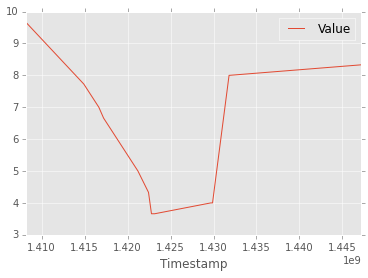

In [13]:
dfTemp1 = dfAll[dfAll.DefIndex == 30279]
dfTemp2 = dfTemp1[dfTemp1.QualInt == 6]
dfTemp2.plot('Timestamp', 'Value')
dfTemp3 = dfTemp1[dfTemp1.QualInt == 13]
dfTemp3.set_title("thing")
dfTemp3.plot('Timestamp', 'Value')



# Working with Nithin's code

In [20]:
dfIn = pd.read_csv('itemhistory.csv', dtype={'Craft':str, 'DateTime':dt.datetime, 'DefIndex':np.float64, 'Name':str,
                                            'PriceIndex':str, 'QualInt':np.int64, 'Trade':str, 'currency':str,
                                            'timestamp':np.float64, 'value':np.float64, 'value_high':np.float64})
dfIn['DateTime'] = pd.to_datetime(dfIn['DateTime'])
dfIn = dfIn.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
dfIn.sort_index(inplace = True)
df2 = dfIn.reset_index()

In [21]:
item_counts=df2['Name'].value_counts()
item_counts

Earbuds                                             468
Team Captain                                        418
Villain's Veil                                      400
Stainless Pot                                       391
Exquisite Rack                                      389
El Jefe                                             384
Master's Yellow Belt                                376
Mann Co. Supply Crate                               375
Bonk Boy                                            374
Glengarry Bonnet                                    363
Détective Noir                                      342
Frenchman's Beret                                   337
Le Party Phantom                                    334
Prince Tavish's Crown                               325
Archimedes                                          318
Magistrate's Mullet                                 316
Pyromancer's Mask                                   312
Vintage Tyrolean                                

In [22]:
count = 0
mostPopular = []
for key, value in item_counts.iteritems():
    if count == 5:
        break
    mostPopular.append(key)
    count = count + 1

In [23]:
df5 = df2.query("Name in @mostPopular")

In [25]:
df5

Name  DefIndex  QualInt     Trade          Craft PriceIndex  \
16493         Earbuds       143        3  Tradable      Craftable          0   
16494         Earbuds       143        3  Tradable      Craftable          0   
16495         Earbuds       143        3  Tradable      Craftable          0   
16496         Earbuds       143        3  Tradable      Craftable          0   
16497         Earbuds       143        3  Tradable      Craftable          0   
16498         Earbuds       143        3  Tradable      Craftable          0   
16499         Earbuds       143        3  Tradable      Craftable          0   
16500         Earbuds       143        3  Tradable      Craftable          0   
16501         Earbuds       143        3  Tradable      Craftable          0   
16502         Earbuds       143        3  Tradable      Craftable          0   
16503         Earbuds       143        3  Tradable      Craftable          0   
16504         Earbuds       143        3  Tradable      Craftable          0   
16505         Earbuds       143        3  Tradable      Craftable          0   
16506         Earbuds       143        3  Tradable      Craftable          0   
16507         Earbuds       143        3  Tradable      Craftable          0   
16508         Earbuds       143        3  Tradable      Craftable          0   
16509         Earbuds       143        3  Tradable      Craftable          0   
16510         Earbuds       143        3  Tradable      Craftable          0   
16511         Earbuds       143        3  Tradable      Craftable          0   
16512         Earbuds       143        3  Tradable      Craftable          0   
16513         Earbuds       143        3  Tradable      Craftable          0   
16514         Earbuds       143        3  Tradable      Craftable          0   
16515         Earbuds       143        3  Tradable      Craftable          0   
16516         Earbuds       143        3  Tradable      Craftable          0   
16517         Earbuds       143        3  Tradable      Craftable          0   
16518         Earbuds       143        3  Tradable      Craftable          0   
16519         Earbuds       143        3  Tradable      Craftable          0   
16520         Earbuds       143        3  Tradable      Craftable          0   
16521         Earbuds       143        3  Tradable      Craftable          0   
16522         Earbuds       143        3  Tradable      Craftable          0   
...               ...       ...      ...       ...            ...        ...   
56792  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56793  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56794  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56795  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56796  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56797  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56798  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56799  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56800  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56801  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56802  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56803  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56804  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56805  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56806  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56807  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56808  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56809  Villain's Veil       393       11  Tradable  Non-Craftable          0   
56810  Villain's 

In [44]:
#plot1 = df5[df5.Name == 'Earbuds']
#plot1.plot('DateTime','value')
#plot2 = df5[df5.Name == 'Team Captain']
#plot2.plot('DateTime','value')
#plot3 = df5[df5.Name == "Villain's Veil"]
#plot3.plot('DateTime','value')
plot4 = df5[df5.Name == 'Stainless Pot']
plot4Qual = plot4.QualInt
plot4Qual = plot4Qual.drop_duplicates('last')
for quality in plot4Qual:
    print quality
#plot4.plot('DateTime','value')
#plot5 = df5[df5.Name == 'Exquisite Rack']
#plot5.plot('DateTime','value')

1
3
5
6
14


Earbuds
3
6
Team Captain
5
6
Villain's Veil
5
6
11
Stainless Pot
1
3
5
6
14
Exquisite Rack
5
6
14


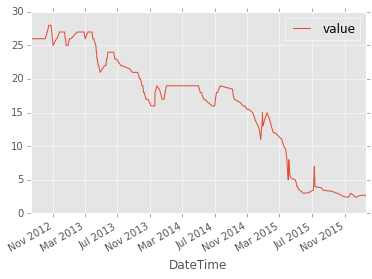

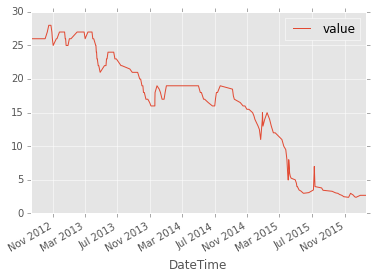

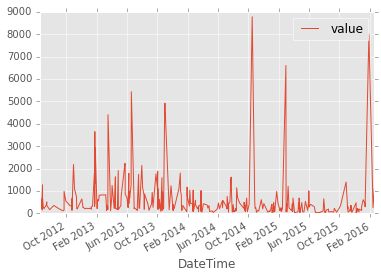

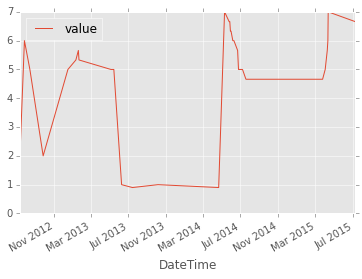

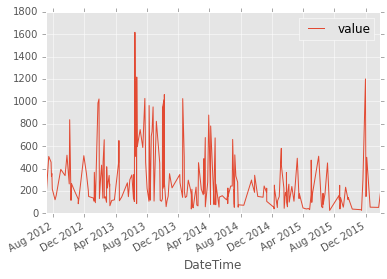

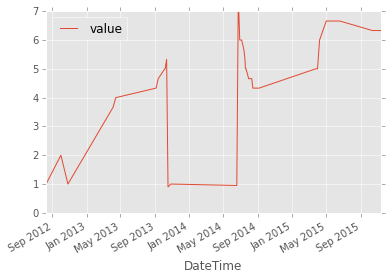

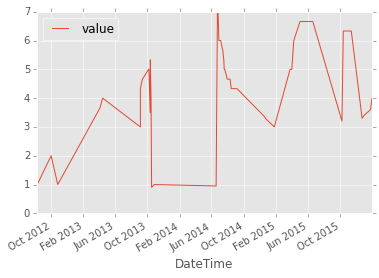

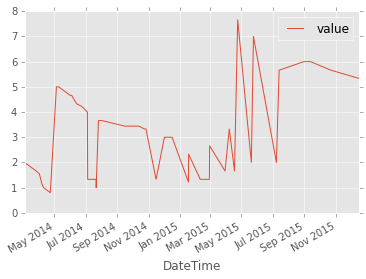

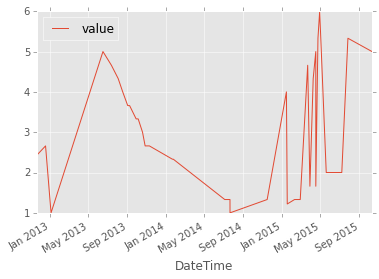

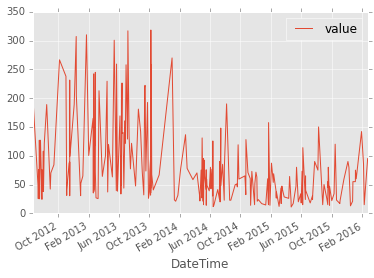

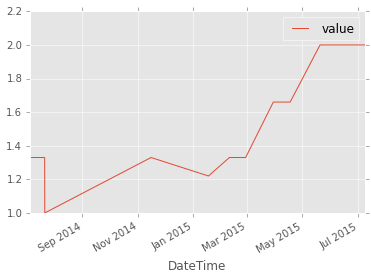

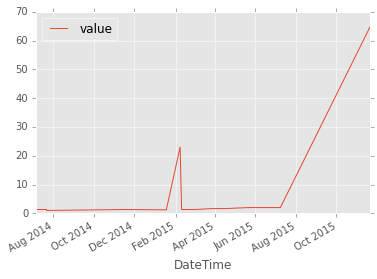

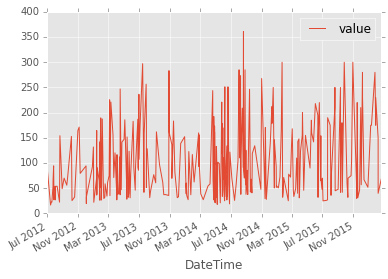

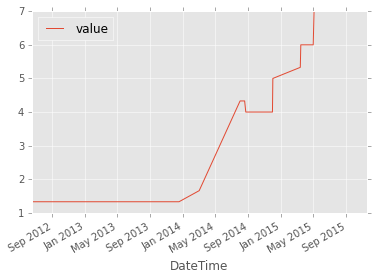

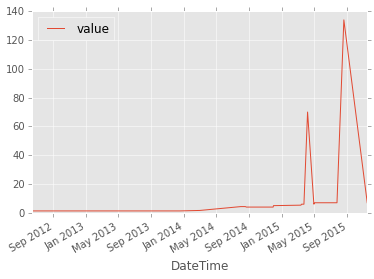

In [49]:
for item in mostPopular:
    plot1 = df5[df5.Name == item]
    plot1Qual = plot1.QualInt.drop_duplicates('last')
    print item
    for quality in plot1Qual:
        plot2 = plot1[plot1.QualInt == quality]
        print quality
        plot2.plot('DateTime','value')

In [11]:
#Could be useful if a json ends up with a lot of data in one column

def flattenColumn(input, column):
    column_flat = pd.DataFrame([[i, c_flattened] for i, y in input[column].apply(list).iteritems() for c_flattened in y], columns=['I', column])
    column_flat = column_flat.set_index('I')
    return input.drop(column, 1).merge(column_flat, left_index=True, right_index=True)

In [ ]:
# df = json_normalize(data2['response'])
# new_df = flattenColumn(df, 'items.A Brush with Death.defindex')


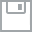
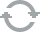
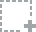
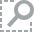
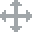
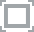
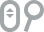
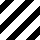
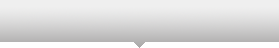
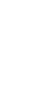
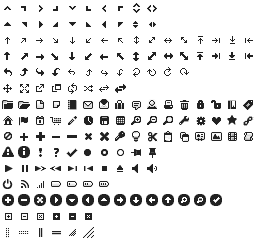
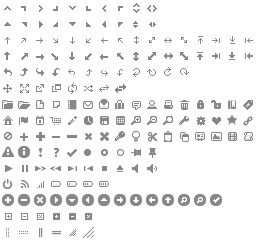
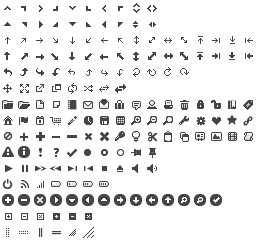
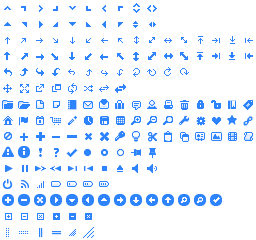
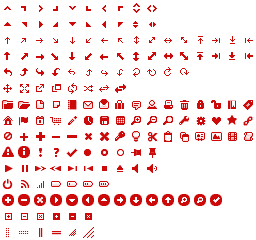
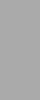
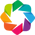
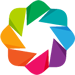

In [7]:
from bokeh.charts import Scatter, show
from bokeh.io import output_notebook
output_notebook()

In [95]:
fig1 = Scatter(dfNew,x='QualInt',y='Value', color='Currency', legend='top_right')
show(fig1)

In [96]:
fig2 = Scatter(dfNew,x='Craft',y='Value', color='Currency', legend='top_right')
show(fig2)

In [97]:
fig3 = Scatter(dfNew,x='PriceIndex',y='Value', color='Currency', legend='top_right')
show(fig3)

In [93]:
fig3 = Scatter(dfNew,x='DefIndex',y='Value', color='Currency', legend='top_right')
show(fig3)

In [98]:
# DefIndex
# <2000 appears to be weapons, hats
# 50xx appears to be paint
# 89xx Transmogrifier, Enchantment/Halloween spells, Glitched Circuit Board
# 20001 is Chemistry Set
# 30xxx is cosmetics

In [7]:
temp = dfNew[dfNew.DefIndex > 8000]
temp = temp[temp.DefIndex < 10000]
temp

Name  DefIndex  QualInt  \
4374                      Demo Costume Transmogrifier      8929        6   
5020                          Enchantment: Eternaween      8937        6   
5029                  Engineer Costume Transmogrifier      8934        6   
6573                           Glitched Circuit Board      8938        6   
6934       Halloween Spell: Bruised Purple Footprints      8919        6   
6935            Halloween Spell: Chromatic Corruption      8902        6   
6936          Halloween Spell: Corpse Gray Footprints      8916        6   
6937      Halloween Spell: Demoman's Cadaverous Croak      8910        6   
6938                         Halloween Spell: Die Job      8901        6   
6939      Halloween Spell: Engineers's Gravelly Growl      8908        6   
6940                        Halloween Spell: Exorcism      8921        6   
6941             Halloween Spell: Gangreen Footprints      8915        6   
6942                  Halloween Spell: Gourd Grenades      8923        6   
6943             Halloween Spell: Headless Horseshoes      8920        6   
6944         Halloween Spell: Heavy's Bottomless Bass      8909        6   
6945   Halloween Spell: Medic's Blood-curdling Bellow      8913        6   
6946         Halloween Spell: Putrescent Pigmentation      8900        6   
6947             Halloween Spell: Pyro's Muffled Moan      8911        6   
6948        Halloween Spell: Rotten Orange Footprints      8918        6   
6949          Halloween Spell: Scout's Spectral Snarl      8906        6   
6950            Halloween Spell: Sentry Quad-Pumpkins      8924        6   
6951               Halloween Spell: Sinister Staining      8904        6   
6952   Halloween Spell: Sniper's Deep Downunder Drawl      8907        6   
6953          Halloween Spell: Soldier's Booming Bark      8905        6   
6954                  Halloween Spell: Spectral Flame      8925        6   
6955               Halloween Spell: Spectral Spectrum      8903        6   
6956              Halloween Spell: Spy's Creepy Croon      8912        6   
6957                  Halloween Spell: Squash Rockets      8922        6   
6958          Halloween Spell: Team Spirit Footprints      8914        6   
6959       Halloween Spell: Violent Violet Footprints      8917        6   
7340                     Heavy Costume Transmogrifier      8930        6   
9689                     Medic Costume Transmogrifier      8931        6   
11861                     Pyro Costume Transmogrifier      8926        6   
12822                    Scout Costume Transmogrifier      8927        6   
13292                   Sniper Costume Transmogrifier      8932        6   
13404                  Soldier Costume Transmogrifier      8928        6   
13646                      Spy Costume Transmogrifier      8933        6   

          Trade      Craft PriceIndex Currency  Value   Last_Update Difference  
4374   Tradable  Craftable          0    metal   0.33  1383269596.0        0.0  
5020   Tradable  Craftable          0    metal   0.05  1450996359.0      -0.03  
5029   Tradable  Craftable          0    metal   0.22  1384061387.0      -0.11  
6573   Tradable  Craftable          0     keys  25.00  1448379969.0     -18.66  
6934   Tradable  Craftable          0     keys  15.00  1449553911.0    277.095  
6935   Tradable  Craftable          0     keys   1.50  1447183092.0    18.1925  
6936   Tradable  Craftable          0     keys   4.00  1445925051.0      16.11  
6937   Tradable  Craftable          0     keys   2.00  1447860332.0        8.5  
6938   Tradable  Craftable          0    metal   6.00  1434994951.0       -6.5  
6939   Tradable  Craftable          0    metal  12.00  1444088602.0       -4.0  
6940   Tradable  Craftable          0     keys   2.00  1447183354.0    20.1375  
6941   Tradable  Craftable          0     keys  45.00  1449719889.0     745.29  
6942   Tradable  Craftable          0     keys   1.00  1428108469.0     13.275  
6943   Tradable  Craftable

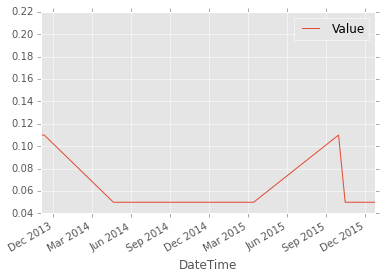

In [28]:
dfTemp1 = dfAll[dfAll.DefIndex == 8937]
fig1 = Scatter(dfTemp1,x='DateTime', y='Value')
show(fig1)
dfTemp1.plot('DateTime','Value')